In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install catboost

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.metrics import make_scorer
from catboost import CatBoost
from catboost import Pool
from lightgbm import LGBMRegressor

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Прежде всего создадим функцию, с помощью которой мы можем увидим полную картину по каждому датасету: **первые 10 строк, кол-во строк, наличие пропусков и дубликатов.**

In [6]:
def full_info(data):
    print('Строки данных')
    display(data.head(10))
    print('_____________________________________________________________________________________________________________')
    print('Статистические данные')
    display(data.describe())
    print('_____________________________________________________________________________________________________________')
    print('Общая информация датафрейма')
    display(data.info())
    print('_____________________________________________________________________________________________________________')
    print('Количество дупликатов в данных')
    display(data.duplicated().sum())
    print('_____________________________________________________________________________________________________________')
    print('Количество пропусках в данных в процентах')
    report = data.isna().sum().to_frame()
    report = report.rename(columns = {0: 'missing_values'})
    report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)
    report.sort_values(by = 'missing_values', ascending = False)
    display(report)
    print('_____________________________________________________________________________________________________________')

# Разбор информации по данным о подаче сыпучих материалов






In [7]:
arc = pd.read_csv('/content/data_arc.csv')
bulk = pd.read_csv('/content/data_bulk.csv')
bulk_time = pd.read_csv('/content/data_bulk_time.csv')
gaz = pd.read_csv('/content/data_gas.csv')
time = pd.read_csv('/content/data_temp.csv')
wire = pd.read_csv('/content/data_wire.csv')
wire_time = pd.read_csv('/content/data_wire_time.csv')

In [8]:
#bulk = pd.read_csv('/content/data_bulk.csv')
#bulk.to_csv('/content/data_bulk.csv', index=False)
full_info(bulk)

Строки данных


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


_____________________________________________________________________________________________________________
Статистические данные


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


_____________________________________________________________________________________________________________
Общая информация датафрейма
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

_____________________________________________________________________________________________________________
Количество дупликатов в данных


0

_____________________________________________________________________________________________________________
Количество пропусках в данных в процентах


,missing_values,% of total
key,0,0.00
Bulk 1,2877,0.92
Bulk 2,3107,0.99
Bulk 3,1831,0.59
Bulk 4,2115,0.68
Bulk 5,3052,0.98
Bulk 6,2553,0.82
Bulk 7,3104,0.99
Bulk 8,3128,1.00
Bulk 9,3110,0.99


_____________________________________________________________________________________________________________


В данном датасете мы видим очень много пропусков. Пропуски в нашем случае означает, что какой-то из  материалов не подавали, а значит в исследовательской части мы можем заменить наши пропуски на **0**.


In [9]:
#bulk_time = pd.read_csv('/content/data_bulk_time.csv')
#bulk_time.to_csv('/content/data_bulk_time.csv', index=False)
full_info(bulk_time)

Строки данных


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


_____________________________________________________________________________________________________________
Статистические данные


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


_____________________________________________________________________________________________________________
Общая информация датафрейма
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

_____________________________________________________________________________________________________________
Количество дупликатов в данных


0

_____________________________________________________________________________________________________________
Количество пропусках в данных в процентах


,missing_values,% of total
key,0,0.00
Bulk 1,2877,0.92
Bulk 2,3107,0.99
Bulk 3,1831,0.59
Bulk 4,2115,0.68
Bulk 5,3052,0.98
Bulk 6,2553,0.82
Bulk 7,3104,0.99
Bulk 8,3128,1.00
Bulk 9,3110,0.99


_____________________________________________________________________________________________________________


При общем сравнении, данные о пропусках в этом и предыдущем датафрейме совпадают

# Разбор информации по данным о температуре

In [10]:
#time = pd.read_csv('/content/data_temp.csv')
#time.to_csv('/content/data_temp.csv', index=False)

In [11]:
full_info(time)

Строки данных


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


_____________________________________________________________________________________________________________
Статистические данные


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


_____________________________________________________________________________________________________________
Общая информация датафрейма
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

_____________________________________________________________________________________________________________
Количество дупликатов в данных


0

_____________________________________________________________________________________________________________
Количество пропусках в данных в процентах


,missing_values,% of total
key,0,0.00
Время замера,0,0.00
Температура,2901,0.18


_____________________________________________________________________________________________________________


В первую очередь, приведем столбец со временем замера в правильный формат при помощи функции **pd.to_datetime**

In [12]:
time['Время замера'] = pd.to_datetime(time['Время замера'], format='%Y-%m-%dT%H:%M:%S')

В некоторых строках по температуре есть пропуски. На основании задания мы можем сказать, что данный столбец имеет ключевое для нас значение и будет скорее всего нашим **таргетом** в исследовании.  
В данном датафрейме мы видим, что значений **key** может быть несколько, а значит у нас в таблице несколько значений температуры для каждого номера партии. Проверим, много ли их через **value_counts()**

In [13]:
time['key'].value_counts()

46      16
1214    16
44      16
1513    16
2108    15
        ..
1160     2
982      2
2456     2
195      1
279      1
Name: key, Length: 3216, dtype: int64

Для примера возьмем партию под номером **"2"**. В данной партии мы видим, что было **6** замеров температуры

In [14]:
time[time['key'] == 2]

,key,Время замера,Температура
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0
10,2,2019-05-03 11:59:12,1602.0


Мы не можем использовать все значения температуры, а значит на каждой партии  нам будет необходимо выделить **начальное значение** замера температуры и **конечное значение** замера температуры. В исследовательской части будет необходимо преобразовать таблицу. 
Кроме того, мы должны помнить о пропусках в температуре. Такие пропуски мы не сможем заменить нулями или средним значением, их в дальнейшем будет необходимо удалить.

# Разбор информации о продувке сплава газом

In [15]:
#gaz = pd.read_csv('/content/data_gas.csv')
#gaz.to_csv('/content/data_gas.csv', index=False)
full_info(gaz)

Строки данных


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


_____________________________________________________________________________________________________________
Статистические данные


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


_____________________________________________________________________________________________________________
Общая информация датафрейма
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

_____________________________________________________________________________________________________________
Количество дупликатов в данных


0

_____________________________________________________________________________________________________________
Количество пропусках в данных в процентах


,missing_values,% of total
key,0,0.0
Газ 1,0,0.0


_____________________________________________________________________________________________________________


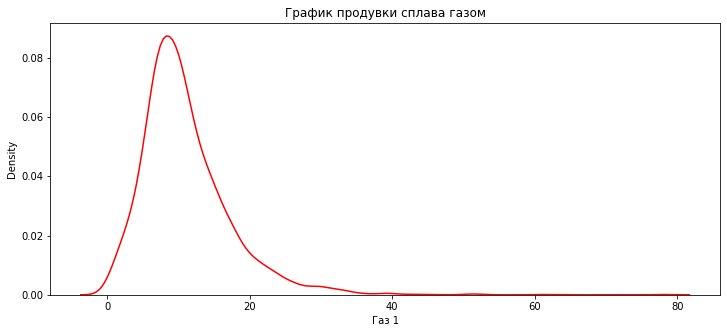

In [16]:
plt.figure(figsize=(12, 5))
fig = sns.kdeplot(gaz['Газ 1'], legend=True, color = 'red')
plt.title('График продувки сплава газом')
plt.show()

Пропуски в таблице отсутствуют, дубликаты также отсутствуют

# Разбор информации по данным о проволочных материалах

In [17]:
#wire = pd.read_csv('/content/data_wire.csv')
#wire.to_csv('/content/data_wire.csv', index=False)
full_info(wire)

Строки данных


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


_____________________________________________________________________________________________________________
Статистические данные


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


_____________________________________________________________________________________________________________
Общая информация датафрейма
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

_____________________________________________________________________________________________________________
Количество дупликатов в данных


0

_____________________________________________________________________________________________________________
Количество пропусках в данных в процентах


,missing_values,% of total
key,0,0.00
Wire 1,26,0.01
Wire 2,2002,0.65
Wire 3,3018,0.98
Wire 4,3067,1.00
Wire 5,3080,1.00
Wire 6,3008,0.98
Wire 7,3070,1.00
Wire 8,3062,0.99
Wire 9,3052,0.99


_____________________________________________________________________________________________________________


В данном датасете очень много пропусков, могу предположить, что определенные материалы, как и в таблице о подаче сыпучих материалов, подаются в определенные партии. Их в дальнейшем можно будет заменить на **0**. 

In [18]:
#wire_time = pd.read_csv('/content/data_wire_time.csv')
#wire_time.to_csv('/content/data_wire_time.csv', index=False)
full_info(wire_time)

Строки данных


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


_____________________________________________________________________________________________________________
Статистические данные


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


_____________________________________________________________________________________________________________
Общая информация датафрейма
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

_____________________________________________________________________________________________________________
Количество дупликатов в данных


0

_____________________________________________________________________________________________________________
Количество пропусках в данных в процентах


,missing_values,% of total
key,0,0.00
Wire 1,26,0.01
Wire 2,2002,0.65
Wire 3,3018,0.98
Wire 4,3067,1.00
Wire 5,3080,1.00
Wire 6,3008,0.98
Wire 7,3070,1.00
Wire 8,3062,0.99
Wire 9,3052,0.99


_____________________________________________________________________________________________________________


# Разбор информации по данным об электродах

In [19]:
#arc = pd.read_csv('/content/data_arc.csv')
#arc.to_csv('/content/data_arc.csv', index=False)
full_info(arc)

Строки данных


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


_____________________________________________________________________________________________________________
Статистические данные


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


_____________________________________________________________________________________________________________
Общая информация датафрейма
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

_____________________________________________________________________________________________________________
Количество дупликатов в данных


0

_____________________________________________________________________________________________________________
Количество пропусках в данных в процентах


,missing_values,% of total
key,0,0.0
Начало нагрева дугой,0,0.0
Конец нагрева дугой,0,0.0
Активная мощность,0,0.0
Реактивная мощность,0,0.0


_____________________________________________________________________________________________________________


Из обзора даных, очень сильно бросается в глаза минимальное значение в столбце **Реактивная мощность**. Далее будет необходимо проверить, является ли это значение аномальным, и можно ли его удалить.

Приведем время нагрева в правильный формат при помощи **pd.to_datetime**

In [20]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

Для того чтобы разобраться с мощностями, какие из них использовать и что они значат обратимся к источникам в Интернете. Но прежде попытаемся проверить, есть ли какая между ними зависимость
 

**Активная «полезная» мощность** — это та часть мощности, которая характеризует непосредственно процесс преобразования электрической энергии в некую другую энергию.
Источник: *https://odinelectric.ru/knowledgebase/aktivnaja-i-reaktivnaja-moshhnost-peremennogo-toka*

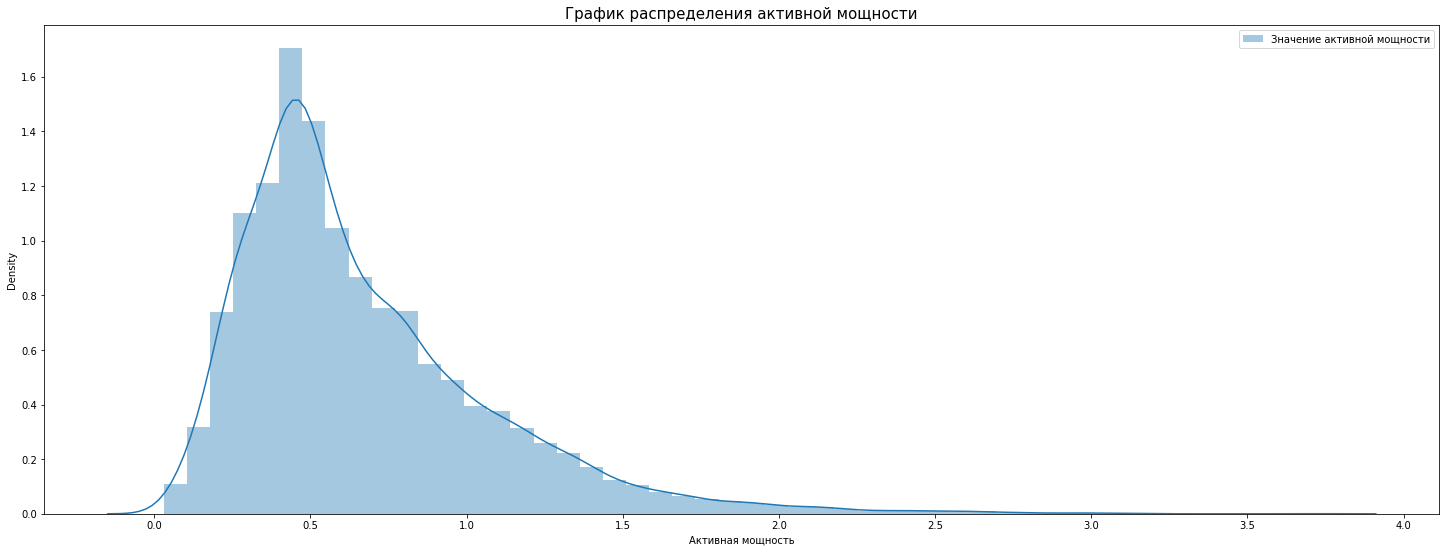

In [21]:
plt.figure(figsize = [25,9])
sns.distplot(arc['Активная мощность'], label = 'Значение активной мощности')
plt.title('График распределения активной мощности', fontsize = 15)
plt.legend()
plt.show()

Данные распределены нормально, каких либо выбивающихся значений нет. Обратимся к реактивной мощности. 

**Реактивная «вредная» мощность** — это мощность, которая образуется в процессе работы электроприборов с индуктивной или емкостной нагрузкой, и отражает происходящие электромагнитные колебания. Проще говоря, это энергия, которая переходит от источника питания к потребителю, а потом возвращается обратно в сеть.
Источник: *https://odinelectric.ru/knowledgebase/aktivnaja-i-reaktivnaja-moshhnost-peremennogo-toka*

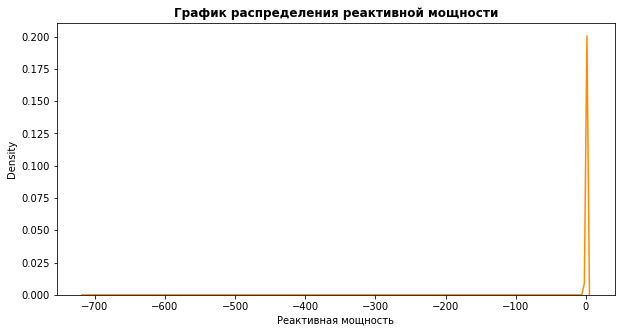

In [22]:
plt.figure(figsize=(10, 5))
fig = sns.kdeplot(arc['Реактивная мощность'], color='darkorange',legend=True)
plt.title('График распределения реактивной мощности', fontweight='bold')
plt.show()

Мы видим как отрицательное значение резко выбивает "стройность графика". В остальном данные распределены нормально. Хотел соединить обе мощности на одном графике до удаления аномального значения, но из за отрицательного значения график не выглядит информативным. В дальнейшем проведем **корреляционный анализ** данных двух мощностей, и в результате чего решим, использовать ли нам одну из мощностей или можно будет каким либо образом объединить значения двух данных столбцов.

# Вывод по первой части

Мы рассмотрели каждую таблицу, предоставили о каждой общую информацию. В следующей главе нам будет необходимо сделать следующие шаги:

1.   заменить пропуски на 0 в таблицах bulk и wire
2.   удалить пропуски в температуре в таблице time
3.   определить начальное и конечное время для каждой партии, а также значение температуры и преобразовать нашу исходную таблицу.
4.   провести корреляционный анализ между активной и реактивной мощностями, проверить аномальное значение, возможно заменить на одно общее значение мощности
5.   реобразовать таблицу с данными по электродам. Возможно создать новую таблицу с использованием pivot_table, где будет необходимо посчитать количество итераций и значение мощности
6.   объединить наши таблицы в одну новую таблицу, используя значение key, убрать лишние значения(возможно это будет время после всех преобразований)  



# Глава вторая. Исследовательская часть

Рассмотрим сначала нашу таблицу с таргетом, температура.

В первую очередь, нам необходимо убрать те значения в которых есть пропуски. По совету наставника если есть пропуск, то убирается вся партия. Кроме того, я решил что есть необходимость также убрать и те партии, в которых есть только одно значение.

Для того, чтобы определить начальное и конечное время воспользуемся группировкой по key и функциями tail и head. После этого объединим наши таблицы, в которой теперь есть начальное время и температуры нагревания и конечное время и температура нагревания.

In [23]:
len(time)

15907

In [24]:
nan_keys = time.loc[time['Температура'].isnull()]['key'].unique()

In [25]:
len(nan_keys)

739

In [26]:
time = time[~time['key'].isin(nan_keys)].reset_index(drop = True)
len(time)

12267

In [27]:
time_group = time.groupby(by = 'key', as_index=False).count()
one_time = time_group[time_group['Время замера']== 1]['key'].tolist()
time = time.query('key not in @one_time')

In [28]:
len(time)

12265

In [29]:
full_info(time)

Строки данных


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


_____________________________________________________________________________________________________________
Статистические данные


,key,Температура
count,12265.000000,12265.000000
mean,1235.751896,1591.998859
std,729.400276,20.834479
min,1.000000,1191.000000
25%,602.000000,1581.000000
50%,1239.000000,1591.000000
75%,1874.000000,1601.000000
max,2499.000000,1705.000000


_____________________________________________________________________________________________________________
Общая информация датафрейма
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12265 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12265 non-null  int64         
 1   Время замера  12265 non-null  datetime64[ns]
 2   Температура   12265 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.3 KB


None

_____________________________________________________________________________________________________________
Количество дупликатов в данных


0

_____________________________________________________________________________________________________________
Количество пропусках в данных в процентах


,missing_values,% of total
key,0,0.0
Время замера,0,0.0
Температура,0,0.0


_____________________________________________________________________________________________________________


In [30]:
temp_end = time.sort_values('Температура').groupby('key').tail(1)
temp_start = time.sort_values('Температура').groupby('key').head(1)
temp_end.head()

,key,Время замера,Температура
9605,1948,2019-07-17 11:18:24,1558.0
6741,1362,2019-06-21 14:18:38,1562.0
9593,1945,2019-07-17 07:23:49,1562.0
857,151,2019-05-09 02:08:56,1565.0
11622,2365,2019-08-01 04:49:09,1566.0


In [31]:
temp_start.head()

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
10127,2052,2019-07-21 14:51:40,1227.0
8914,1818,2019-07-07 00:31:40,1383.0


Объединим две наши таблицы в одну по столбцу **key**

In [32]:
new_temp = temp_start.merge(temp_end, how='inner', on='key')
new_temp = new_temp.dropna()
new_temp = new_temp.sort_values('key')
new_temp = new_temp.rename(columns={'Температура_x': 'start_temperature', 'Температура_y': 'end_temperature'})

Теперь обратимся к таблице с электродами. Как и предполагалось в первой части необходимо найти какую то общую мощность для нашего исследования. Кроме того, удалим наше выбивающееся значение и проверим насколько коррелируют между собой мощности. Для начала найдем определение **Полной мощности**

**Полная мощность** – это геометрически вычисляемая величина, равная корню из суммы квадратов активной и реактивной мощностей соответственно.
Источник: *https://odinelectric.ru/knowledgebase/aktivnaja-i-reaktivnaja-moshhnost-peremennogo-toka*

Удалим все значения, которые меньше нуля. В нашем случае оказалось, что такое значение только одно. После удаления можем проверить как мощности коррелируют друг с другом.

In [33]:
arc = arc[arc['Реактивная мощность'] >= 0]
arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14875 non-null  int64         
 1   Начало нагрева дугой  14875 non-null  datetime64[ns]
 2   Конец нагрева дугой   14875 non-null  datetime64[ns]
 3   Активная мощность     14875 non-null  float64       
 4   Реактивная мощность   14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


Во превых построим корреляционную сетку. Значение корреляции около 96, то же самое показывает и функция **.corr()**.

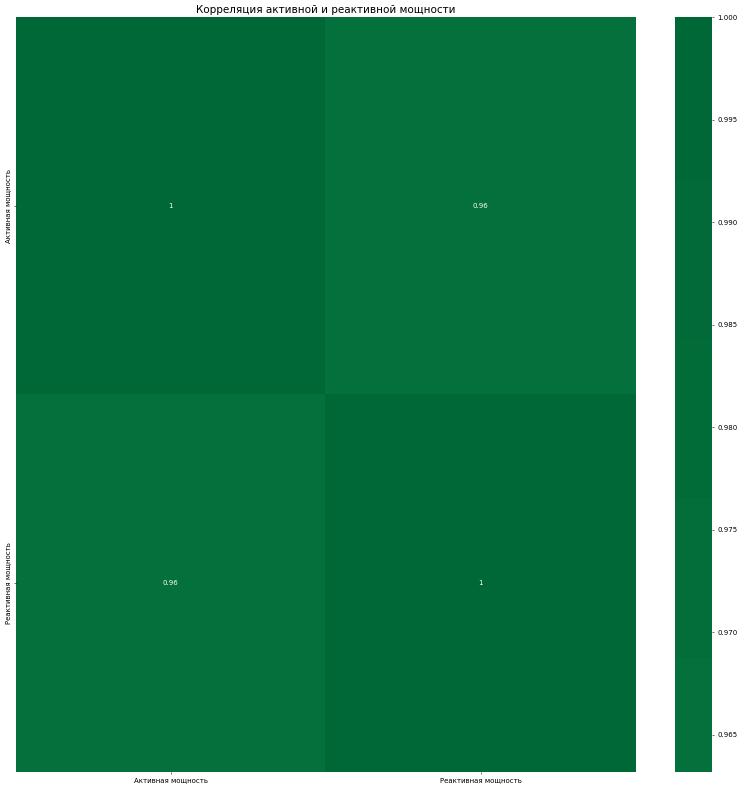

In [34]:
plt.figure(figsize=(20,20), dpi= 50)
sns.heatmap(
    arc[['Активная мощность','Реактивная мощность']].corr(),
    xticklabels=arc[['Активная мощность','Реактивная мощность']].corr().columns, 
    yticklabels=arc[['Активная мощность','Реактивная мощность']].corr().columns, 
    cmap='RdYlGn', center=0, annot=True
            )
plt.title('Корреляция активной и реактивной мощности', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [35]:
correla = arc[['Активная мощность','Реактивная мощность']]
correla.corr()

,Активная мощность,Реактивная мощность
Активная мощность,1.000000,0.963182
Реактивная мощность,0.963182,1.000000


Построим также теперь общий график. Из графика видим, что линии почти идентичны

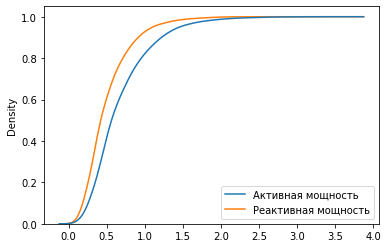

In [36]:
new = arc[['Активная мощность','Реактивная мощность']]
sns.kdeplot(
    data=new,
    cumulative=True, common_norm=False, common_grid=True,
)

Все построенные графики подталкивают нас к тому, что мощности почти взаимосвязаны и взаимозависимы. Из них выведем общее значение (Полная мощность), воспользуемся формулой, и добавим столбец полной мощности в нашу таблицу. Воспользуемся функцией, в которой полная мощность равна корню из суммы квадратов активной и реактивной мощности. После при помощи функции **apply()** добавим новый столбец

In [37]:
def total_power(row):   
    total_power= math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return total_power

In [38]:
arc['Полная мощность'] = arc.apply(total_power, axis=1)
arc_new = arc.copy()
arc_new.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239


Для таблиц wire и bulk заменим пропущенные значения на 0

In [39]:
wire = wire.fillna(0)
wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
bulk = bulk.fillna(0)
bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Добавим новые признаки: просуммируем значения в столбцах с объемом подачи сыпучих материалов и объем подачи проволочных материалов

In [41]:
bulk['bulk_sum'] = bulk.iloc[:,1:].sum(axis = 1)
wire['wire_sum'] = wire.iloc[:,1:].sum(axis = 1)

Вернемся к базе с электродами. Здесь у нас важная задача: мы видим, что есть несколько итераций у каждой партии, нам надо понять сколько всего было итераций, и какое значение полной мощности для каждой партии. Для этого использовал два метода: через groupby(), сначала по количеству делал таблицу потом по сумме и объединял их. Второй вариант попробовал через pivot_table(), результат получился тот же. Наименования столбцов поменял. 

In [42]:
arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239


In [43]:
#df_arc_count = arc.groupby(by = 'key', as_index = False).count()[['key','Начало нагрева дугой']]
#df_arc_count.columns = ['key','Количество итераций нагрева']

#c_arc = arc.groupby(by = 'key', as_index = False).sum()

#new_arc = c_arc.merge(df_arc_count, how='left', on = 'key')
#ew_arc.head(5)

In [44]:
arc_pivot = arc.pivot_table(index = 'key',  
                 values = ['Полная мощность', 'Активная мощность'], 
                 aggfunc = {
                     'Полная мощность':'sum','Активная мощность':'count'
                     }).reset_index().rename(
                         columns={
                             'Активная мощность': 'Iterations', 'Полная мощность': 'total power'
                             })
arc_pivot.head(5)

,key,Iterations,total power
0,1,5,5.826395
1,2,4,3.649216
2,3,5,2.989534
3,4,4,3.814962
4,5,4,4.035758


Объединяем все данные нам таблицы. Присоединять будем по очереди к таблице с температурой **new_temp**, основой для присоединения будет столбец **key** используем merge() для этого

In [45]:
data = (new_temp.merge(arc_pivot, how='left', on='key').merge(wire, how='left', 
                                                              on='key').merge(bulk, how='left', on='key').merge(gaz, how='left', on='key'))

Посмотрим на новую таблицу, проверим на наличие пропусков

In [46]:
full_info(data)

Строки данных


,key,Время замера_x,start_temperature,Время замера_y,end_temperature,Iterations,total power,Wire 1,Wire 2,Wire 3,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum,Газ 1
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:29:11,1618.0,5,5.826395,60.059998,0.000000,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,29.749986
1,2,2019-05-03 11:38:00,1577.0,2019-05-03 11:58:24,1608.0,4,3.649216,96.052315,0.000000,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,12.555561
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:30:48,1599.0,5,2.989534,91.160157,0.000000,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,28.554793
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,4,3.814962,89.063515,0.000000,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,18.841219
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,4,4.035758,89.238236,9.114560,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,5.413692
5,6,2019-05-03 13:49:24,1543.0,2019-05-03 14:11:50,1600.0,4,4.786837,99.109917,9.114560,0.0,...,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,676.0,11.273392
6,7,2019-05-03 14:20:19,1582.0,2019-05-03 14:42:37,1599.0,4,2.987777,98.061600,0.000000,0.0,...,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,627.0,9.836267
7,8,2019-05-03 15:07:18,1577.0,2019-05-03 15:17:09,1604.0,4,4.627389,155.282394,0.000000,0.0,...,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,914.0,15.171553
8,9,2019-05-03 15:37:03,1587.0,2019-05-03 15:51:15,1597.0,5,2.555348,113.393279,9.143681,0.0,...,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,526.0,8.216623
9,10,2019-05-03 16:14:29,1574.0,2019-05-03 16:36:08,1593.0,6,3.851739,81.244796,12.376000,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0,509.0,6.529891


_____________________________________________________________________________________________________________
Статистические данные


,key,start_temperature,end_temperature,Iterations,total power,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum,Газ 1
count,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2372.000000,2372.000000,2372.000000,2372.000000,2372.0,...,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2473.000000
mean,1250.787071,1578.063434,1603.283232,4.625455,3.909335,102.264474,17.856377,3.176273,0.300993,0.0,...,0.020357,0.430411,4.889074,4.107603,209.095970,1.032821,153.823016,116.945160,603.766514,11.142960
std,719.787271,23.788843,18.635642,1.610369,1.778325,43.641222,33.944219,27.691693,4.714583,0.0,...,0.998753,6.119484,20.595391,22.160275,156.242143,14.003687,81.902931,85.582306,287.101451,6.323742
min,1.000000,1191.000000,1558.000000,1.000000,0.257637,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.008399
25%,629.500000,1568.000000,1591.000000,4.000000,2.692521,72.859018,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,430.000000,7.105241
50%,1252.000000,1579.000000,1599.000000,4.000000,3.755583,101.087998,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,106.000000,604.000000,9.926730
75%,1872.500000,1589.000000,1613.000000,6.000000,4.874185,128.143076,23.162880,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,789.000000,13.872219
max,2499.000000,1661.000000,1705.000000,16.000000,21.564771,330.314424,282.780152,385.008668,113.231044,0.0,...,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,3235.000000,77.995040


_____________________________________________________________________________________________________________
Общая информация датафрейма
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2475 non-null   int64         
 1   Время замера_x     2475 non-null   datetime64[ns]
 2   start_temperature  2475 non-null   float64       
 3   Время замера_y     2475 non-null   datetime64[ns]
 4   end_temperature    2475 non-null   float64       
 5   Iterations         2475 non-null   int64         
 6   total power        2475 non-null   float64       
 7   Wire 1             2372 non-null   float64       
 8   Wire 2             2372 non-null   float64       
 9   Wire 3             2372 non-null   float64       
 10  Wire 4             2372 non-null   float64       
 11  Wire 5             2372 non-null   

None

_____________________________________________________________________________________________________________
Количество дупликатов в данных


0

_____________________________________________________________________________________________________________
Количество пропусках в данных в процентах


,missing_values,% of total
key,0,0.00
Время замера_x,0,0.00
start_temperature,0,0.00
Время замера_y,0,0.00
end_temperature,0,0.00
Iterations,0,0.00
total power,0,0.00
Wire 1,103,0.04
Wire 2,103,0.04
Wire 3,103,0.04


_____________________________________________________________________________________________________________


Думал над тем чтобы оставить данные столбцы со временем для Catboost, но решил убрать их пока. Если модель покажет низкме результаты, создам отдельный датасет для Catboost и перенесу их в cat_features

In [47]:
full_data = data.drop(['Время замера_x','Время замера_y'], axis=1)

Есть некоторые пропуски в наших данных, это последствие объединения таблиц. Пропуски незначительны, данные строки решил удалить

In [48]:
full_data = full_data.dropna()

Нашим следующим действием будет проверка некоторых данных на выбросы. Забегая вперед, именно столбцы с начальной и конечной температурой, значение газа очень сильно повлияли на различные модели(проверка важности факторов далее в каждой модели в features_importances)

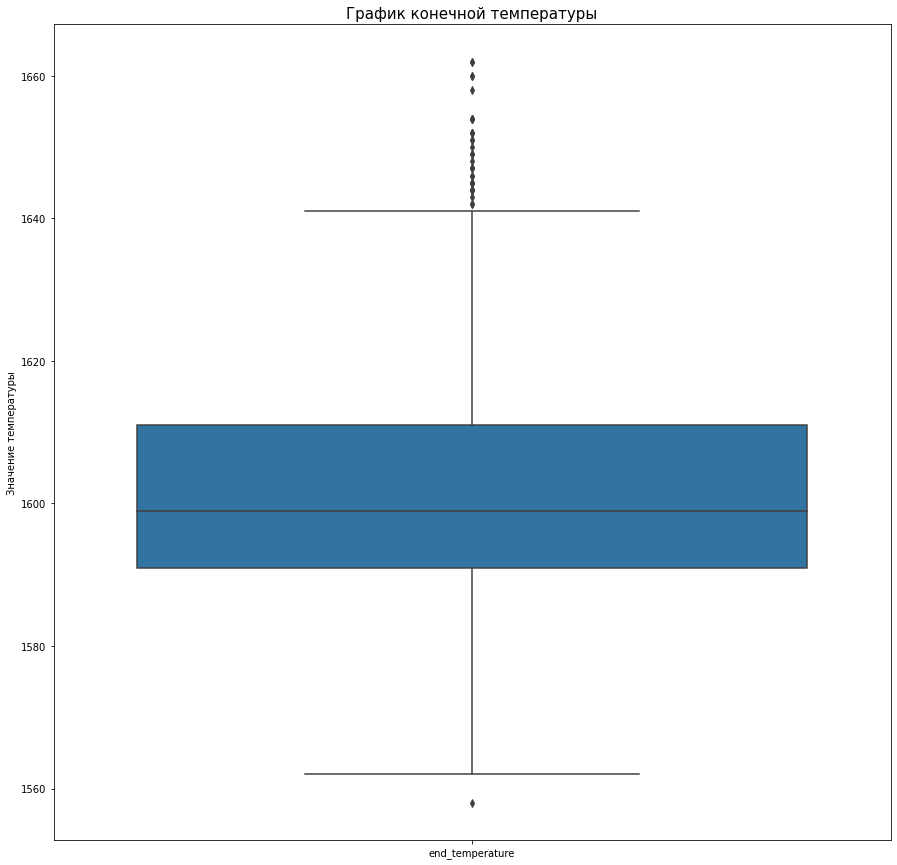

In [49]:
temp_1 = full_data[['end_temperature']]
plt.figure(figsize = (15,15))
sns.boxplot(data = temp_1)
plt.title('График конечной температуры', fontsize = 15)
plt.ylabel('Значение температуры')
plt.show()

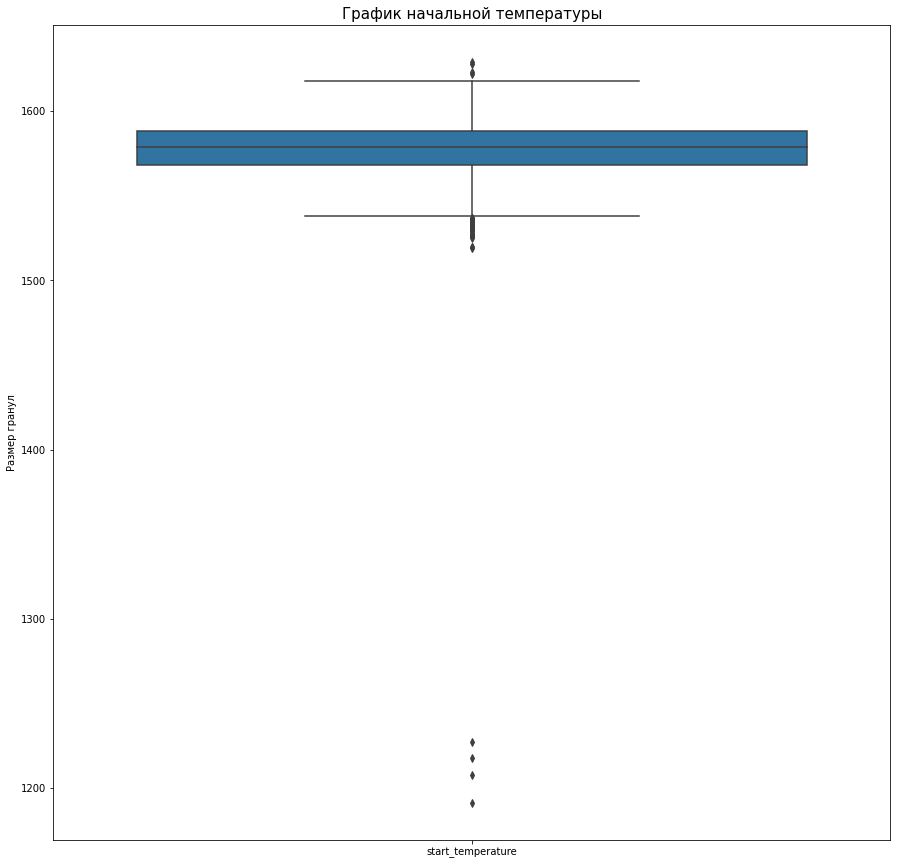

In [50]:
temp_2 = full_data[['start_temperature']]
plt.figure(figsize = (15,15))
sns.boxplot(data = temp_2)
plt.title('График начальной температуры', fontsize = 15)
plt.ylabel('Размер гранул')
plt.show()

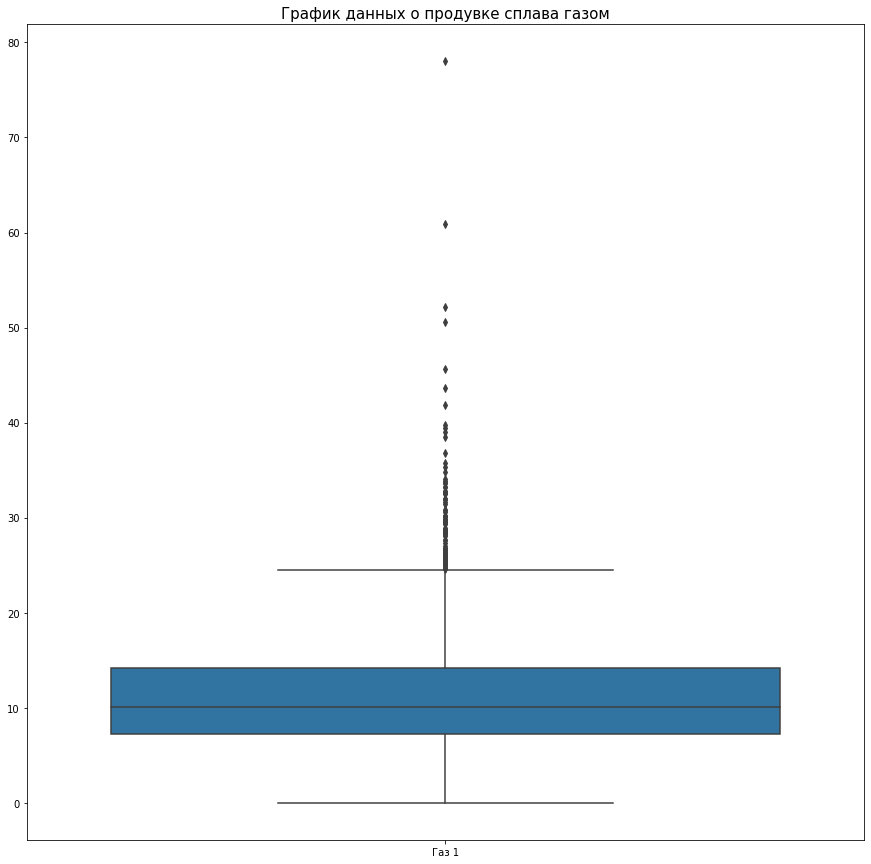

In [51]:
f_new = full_data[['Газ 1']]
plt.figure(figsize = (15,15))
sns.boxplot(data = f_new)
plt.title('График данных о продувке сплава газом', fontsize = 15)
plt.show()

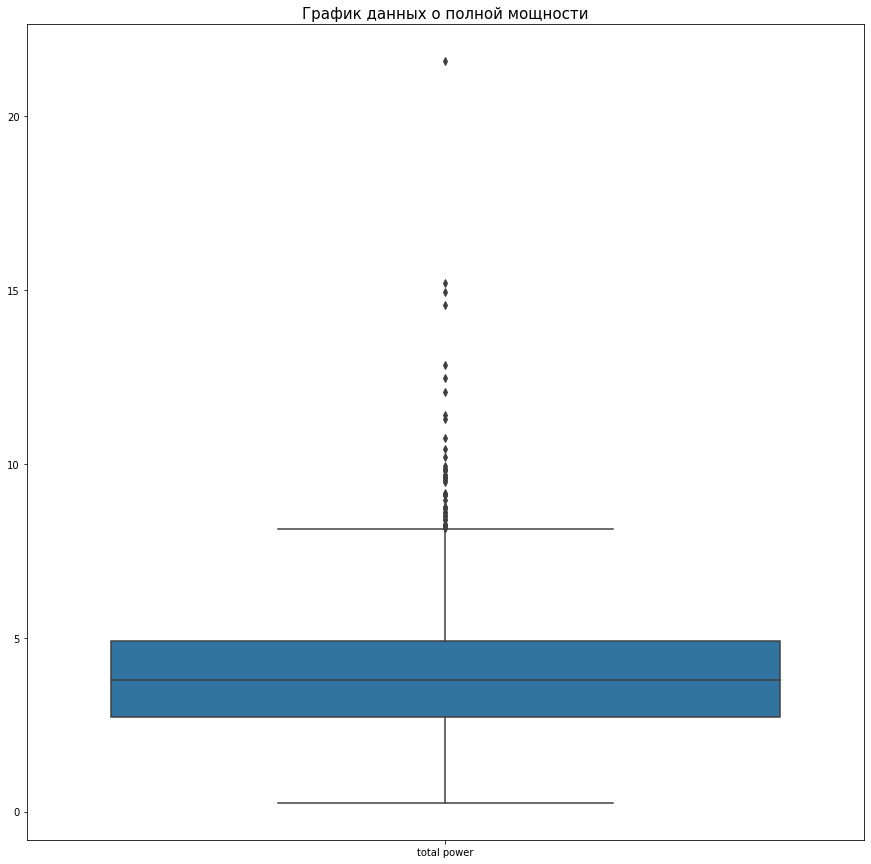

In [52]:
f_new = full_data[['total power']]
plt.figure(figsize = (15,15))
sns.boxplot(data = f_new)
plt.title('График данных о полной мощности', fontsize = 15)
plt.show()

In [53]:
len(full_data.loc[(full_data['Газ 1'] > 30)])

38

In [54]:
len(full_data)

2329

Избавимся от выбросов в данных столбцах, также поменяем название некоторых столбцов

In [55]:
full_data = full_data.loc[
                           (full_data['start_temperature'] > 1300)]
full_data = full_data.loc[
                           (full_data['end_temperature'] < 1640)]
full_data = full_data.loc[
                          (full_data['Газ 1'] < 35)]     
full_data = full_data.loc[
                          (full_data['total power'] < 10)]                  

In [56]:
len(full_data)

2256

In [57]:
full_data = full_data.rename(columns={'Газ 1': 'gaz'})

Проверим все наши столбцы на мультикоррелиарность, построим сетку. Если значения корреляции между двумя столбцами выше 90, один из столбцов тогда удаляем. 

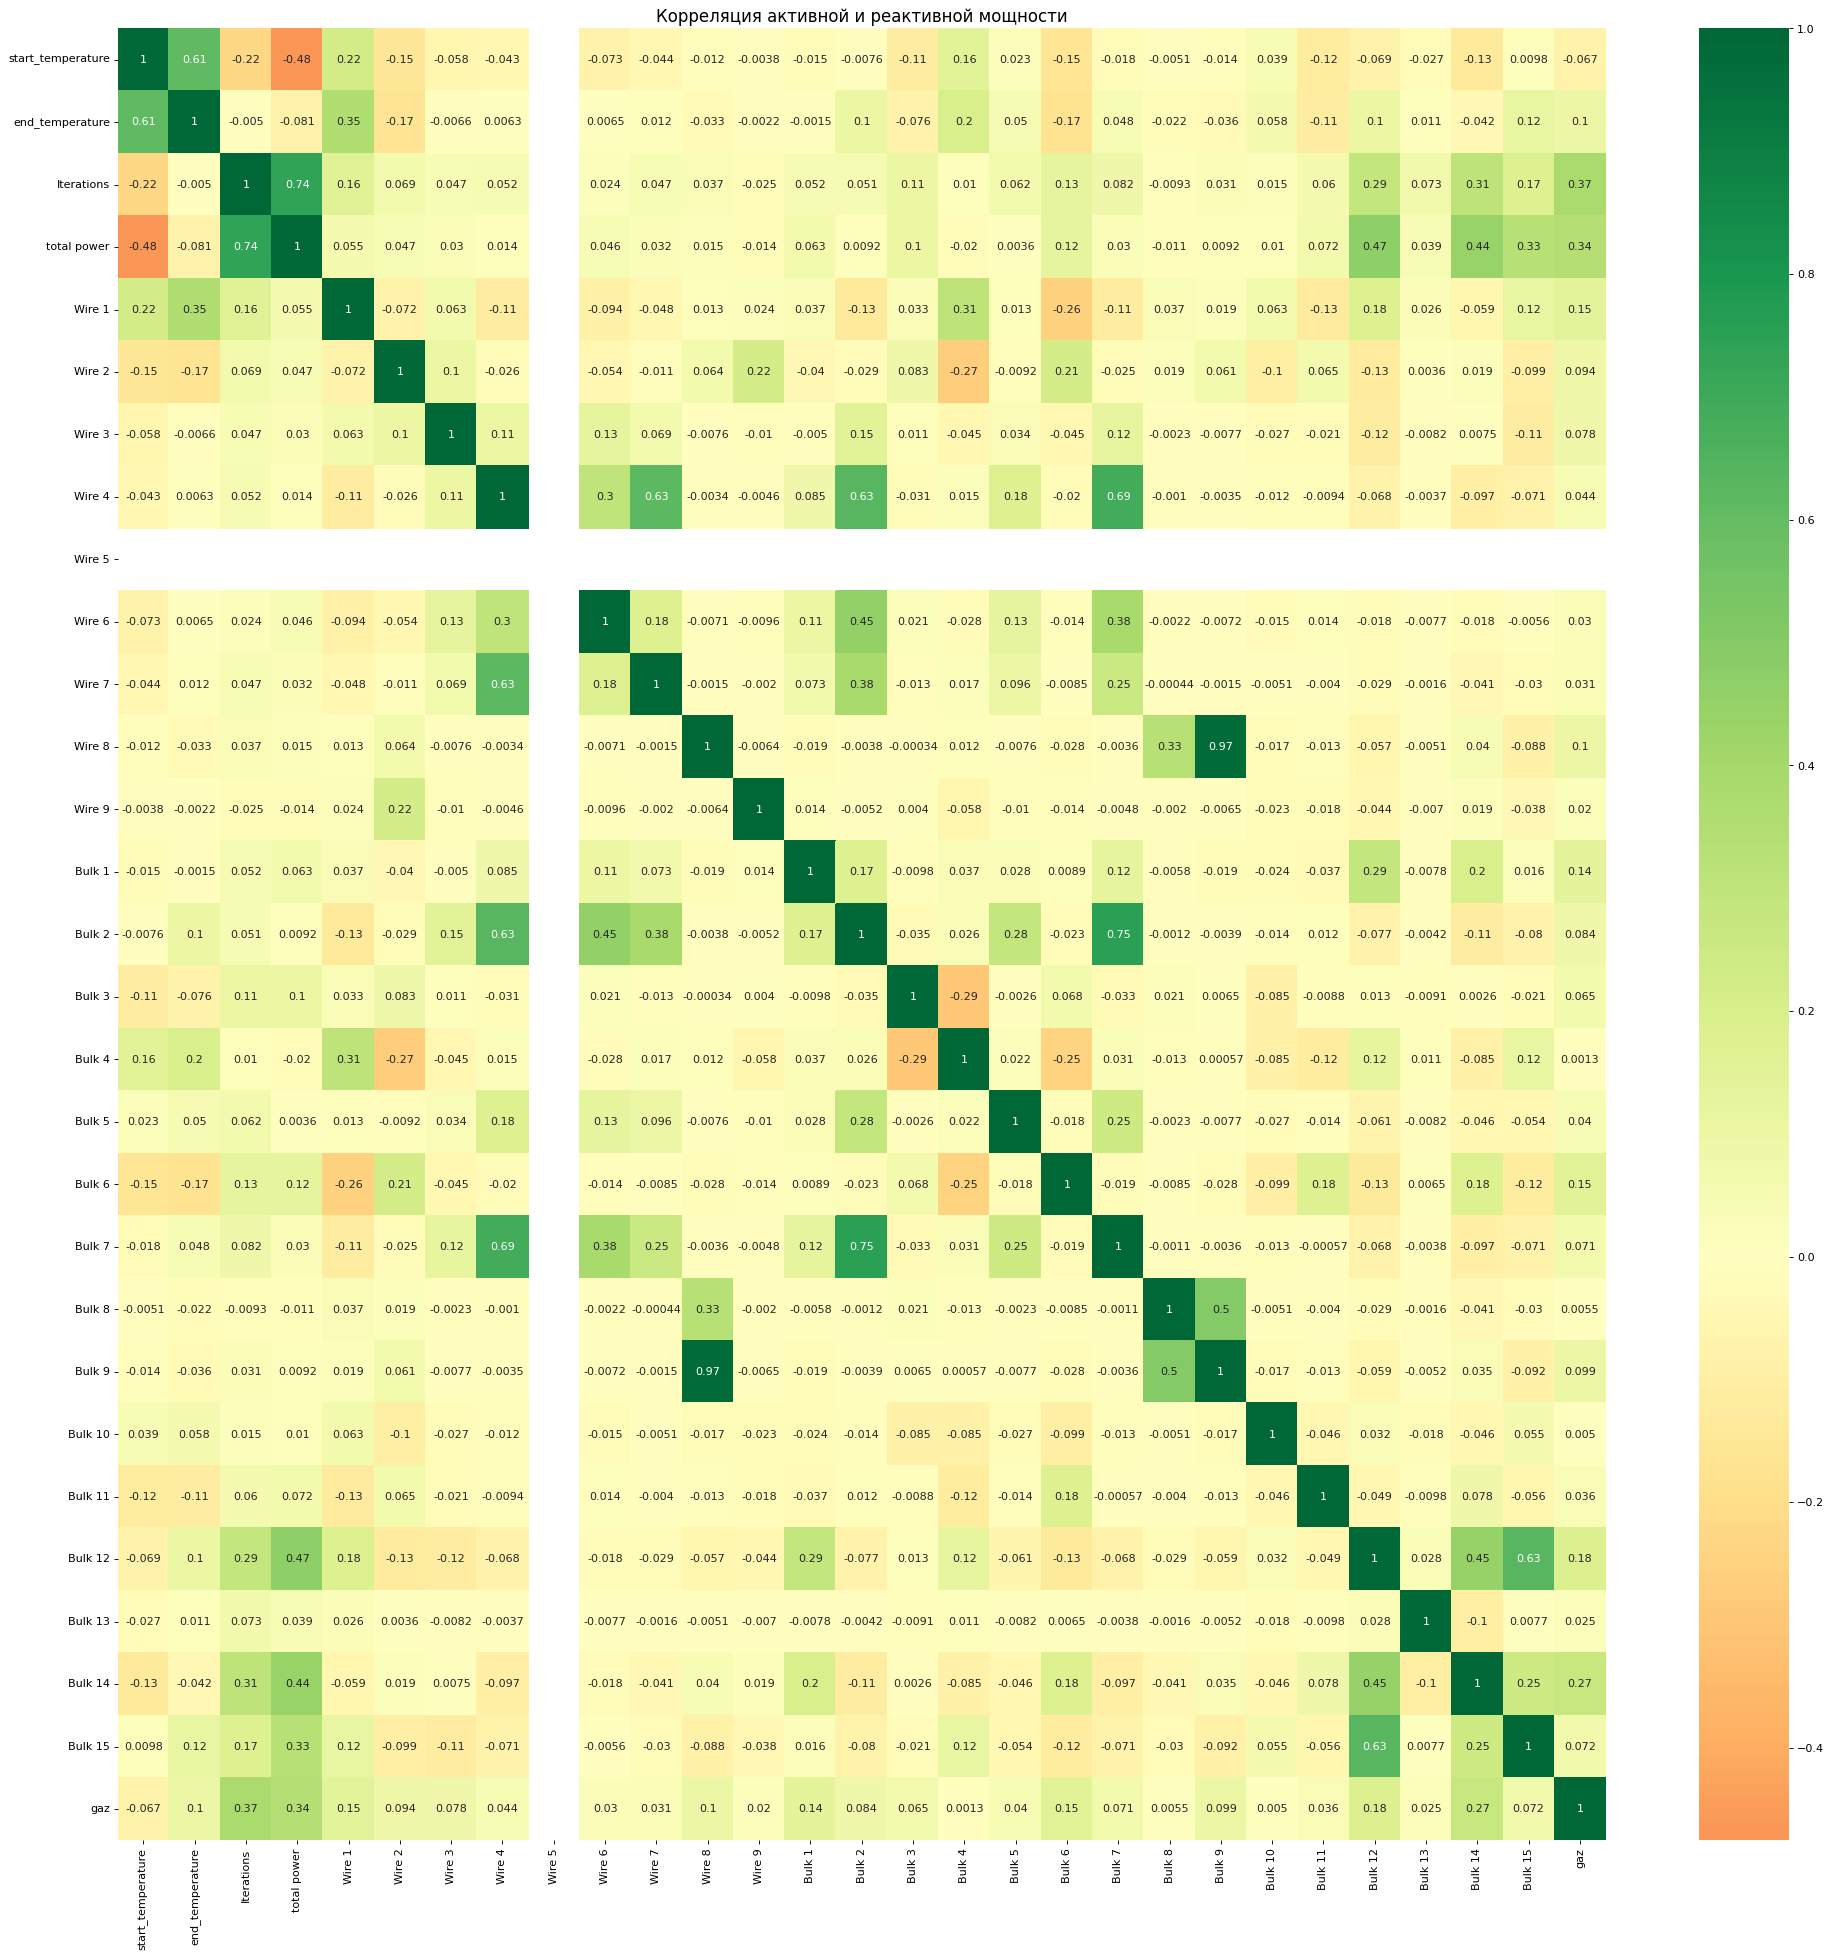

In [58]:
plt.figure(figsize=(30,30), dpi= 80)
sns.heatmap(
    full_data[['start_temperature', 'end_temperature', 'Iterations',
       'total power', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5',
       'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Bulk 1', 'Bulk 2', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10',
       'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'gaz']].corr(),
    xticklabels=full_data[['start_temperature', 'end_temperature', 'Iterations',
       'total power', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5',
       'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Bulk 1', 'Bulk 2', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10',
       'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'gaz']].corr().columns, 
    yticklabels=full_data[['start_temperature', 'end_temperature', 'Iterations',
       'total power', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5',
       'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Bulk 1', 'Bulk 2', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10',
       'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'gaz']].corr().columns, 
    cmap='RdYlGn', center=0, annot=True
            )
plt.title('Корреляция активной и реактивной мощности', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Мы видим, что очень высокая зависимость между столбцами 'Wire 8' и 'Bulk 9'. При определении features и target избавимся также и от одного из этих столбцов.

# Вывод по второй части

Во второй части провели исследовательскую работу. Основной нашей целью было подготовить данные для дальнейшего их использования в наших моделях. Мы еще рассмотрели все данные нам таблицы:

*   в данных о подаче сыпучих и проволоочных материалов мы заменили все наши пропущенные значения на 0, добавили новые признаки(сумма в каждой партии);
*   в данных о электродах мы обосновали замену 2 значений мощности на значение полной мощности, нашли количество итераций, полностью преобразовали таблицу для дальнейшего использования;
*   в данных о температуре нашли начальное и конечное значение;
*   объединили все наши таблицы в одну по значению **key**
*   рассмотрели значения некоторых столбцов на наличие выбросов(сделалось это уже после того как были построены модели и определены факторы, которые очень сильно на них повлияли);
*   проверили столбцы на корреляцию, приняли решение удалить один из таких столбцов 









In [59]:
full_data

,key,start_temperature,end_temperature,Iterations,total power,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum,gaz
0,1,1571.0,1618.0,5,5.826395,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,29.749986
1,2,1577.0,1608.0,4,3.649216,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,12.555561
2,3,1596.0,1599.0,5,2.989534,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,28.554793
3,4,1601.0,1625.0,4,3.814962,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,18.841219
4,5,1576.0,1602.0,4,4.035758,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,4,3.986869,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,719.0,7.125735
2471,2496,1554.0,1595.0,6,5.057033,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,796.0,9.412616
2472,2497,1571.0,1589.0,3,2.885017,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,665.0,6.271699
2473,2498,1570.0,1594.0,5,4.143749,118.110717,0.00000,0.0,0.0,0.0,...,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,733.0,14.953657


# Глава третья. Обучающая часть

Здесь описание и проблемы с которыми столкнулся во время обучения еще не делал, насколько понимаю это нужно сделать в последней части проекта, но сам код уже в принципе готов.

In [60]:
features = full_data.drop(['end_temperature','key','Wire 8'], axis =1)
target = full_data['end_temperature']

features_train, test_features, target_train, test_target = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [61]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
test_features = scaler.transform(test_features)

print(len(target_train))
print(len(features_train))

1804
1804


In [62]:
score_func = make_scorer(mean_absolute_error, greater_is_better = False)

### *Catboost*

In [63]:

final_cat = CatBoostRegressor(iterations = 100, random_state = 12345, loss_function='MAE',verbose=False)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6],
        'l2_leaf_reg': [1, 3, 5, 7]}
train_dataset = Pool(features_train, target_train)
final_cat_grid = final_cat.grid_search(grid,Pool(features_train, target_train),
                              cv = 3, verbose=False)


bestTest = 78.12842925
bestIteration = 99


bestTest = 7.832124608
bestIteration = 99


bestTest = 78.12827719
bestIteration = 99


bestTest = 7.794141428
bestIteration = 99


bestTest = 78.13169654
bestIteration = 99


bestTest = 7.787101201
bestIteration = 99


bestTest = 78.13565884
bestIteration = 99


bestTest = 7.772939658
bestIteration = 99


bestTest = 78.52496782
bestIteration = 99


bestTest = 7.654724096
bestIteration = 99


bestTest = 78.45667555
bestIteration = 99


bestTest = 7.602715053
bestIteration = 98


bestTest = 78.43945032
bestIteration = 99


bestTest = 7.59649582
bestIteration = 95


bestTest = 78.43912213
bestIteration = 99


bestTest = 7.648906897
bestIteration = 99


bestTest = 81.9136384
bestIteration = 99


bestTest = 11.34587018
bestIteration = 94


bestTest = 81.61117322
bestIteration = 99


bestTest = 10.54878568
bestIteration = 98


bestTest = 81.20585194
bestIteration = 99


bestTest = 9.911904543
bestIteration = 99


bestTest = 81.21099355
bestIterat

In [64]:
cat = CatBoostRegressor(iterations = 100, random_state = 12345, loss_function='MAE',verbose=False, depth = 2, l2_leaf_reg = 3, learning_rate = 0.1)

In [65]:
cat.fit(test_features, test_target)
cat_predictions = cat.predict(test_features)
cat_mae = round(mean_absolute_error(test_target, cat_predictions),3)
cat_mae

6.047

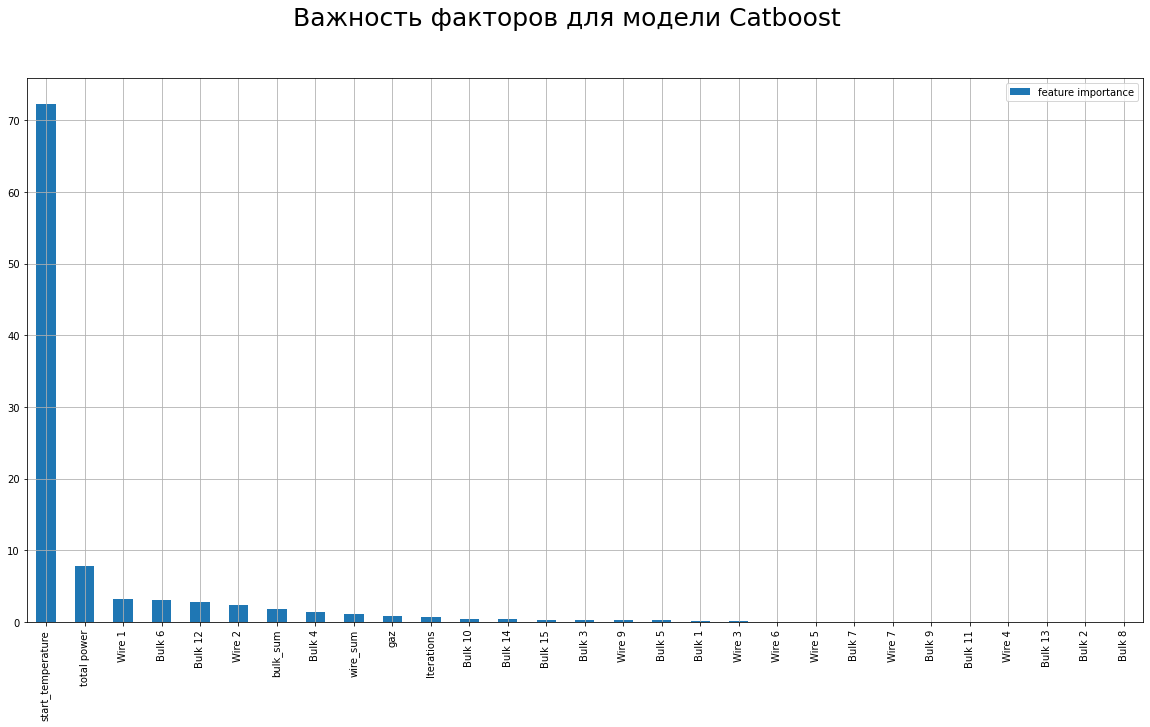

In [66]:
data_importance = pd.DataFrame(cat.feature_importances_, index=features.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
data_importance.plot(kind='bar', grid = True, figsize=(20, 10))
plt.suptitle('Важность факторов для модели Catboost', ha='center', fontsize=25)
plt.show()

### *LGBMRegressor*

In [67]:
%%time
modelLight1 = LGBMRegressor(boosting_type='gbdt', n_jobs = -1, random_state = 12345, n_estimators=100, learning_rate = 0.1
    )
parameters_light = {'depth':range(2,6,2), 'num_leaves': range(10, 14, 2), 
                    'min_child_samples': range(2, 6, 2), 'min_child_weight': range(2, 6, 2), 
                    'reg_lambda': range(1, 8, 2), 'subsample' : [0.3,0.5]}
light = GridSearchCV(modelLight1, parameters_light,
            cv = 3, scoring=score_func,
            verbose = True)
light.fit(features_train, target_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
CPU times: user 1min 32s, sys: 1.57 s, total: 1min 34s
Wall time: 54 s


In [68]:
modelLight = light.best_estimator_
modelLight

LGBMRegressor(depth=2, min_child_samples=2, min_child_weight=2, num_leaves=10,
              random_state=12345, reg_lambda=3, subsample=0.3)

In [69]:
p = modelLight.predict(features_train)
light_f = round(mean_absolute_error(target_train, p),3)
print(light_f)

5.612


In [70]:
light_predict = modelLight.predict(test_features)
light_mae = round(mean_absolute_error(test_target, light_predict),3)
print(light_mae)

6.686


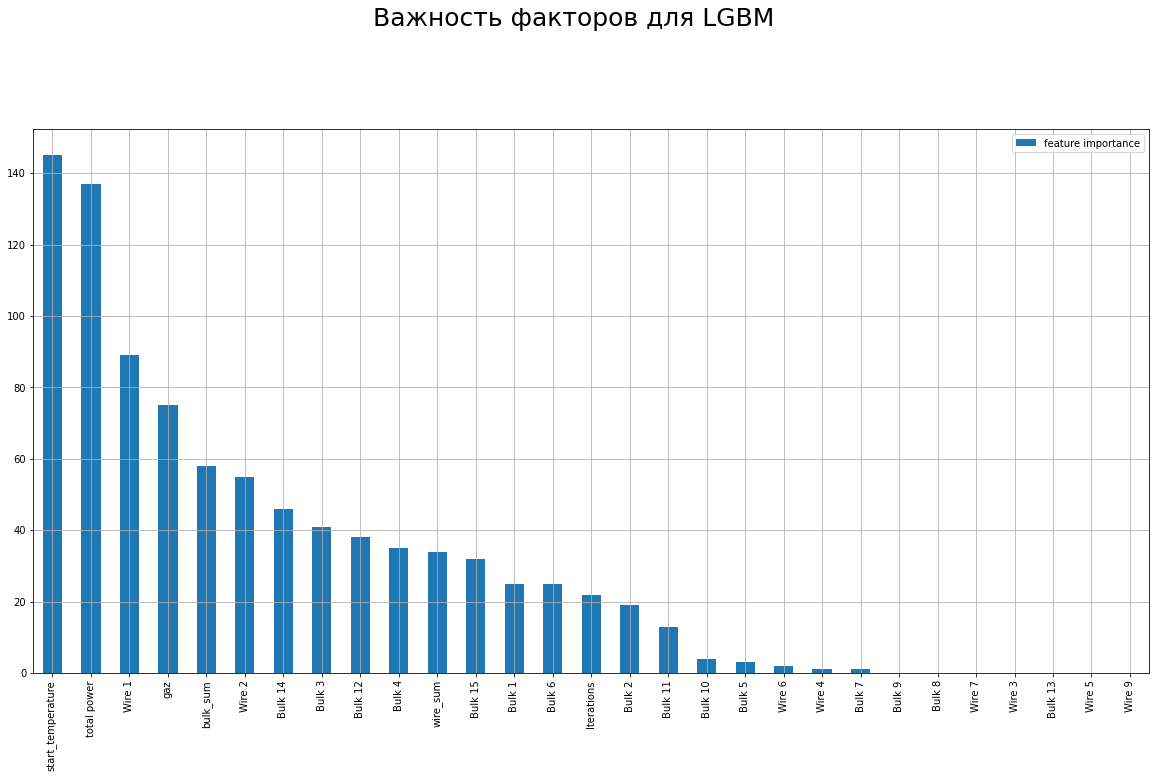

In [71]:
df_feature_importance = pd.DataFrame(modelLight.feature_importances_, index=features.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance.plot(kind='bar', grid = True, figsize=(20, 10))
plt.suptitle('Важность факторов для LGBM', x=0.5, y=1.05, ha='center', fontsize=25)
plt.show()

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
regr = RandomForestRegressor()
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,8,2),
              'random_state':[12345]}

reg1 = GridSearchCV(regr, parametrs, cv = 4, scoring = score_func)
reg1.fit(features_train, target_train)
reg1pred = reg1.predict(features_train)

In [74]:
regr_model =reg1.best_estimator_
regr_model

RandomForestRegressor(max_depth=7, n_estimators=50, random_state=12345)

In [75]:
reg_pre = regr_model.predict(test_features)
reg_mae = round(mean_absolute_error(test_target, reg_pre),3)
print(reg_mae)

6.849


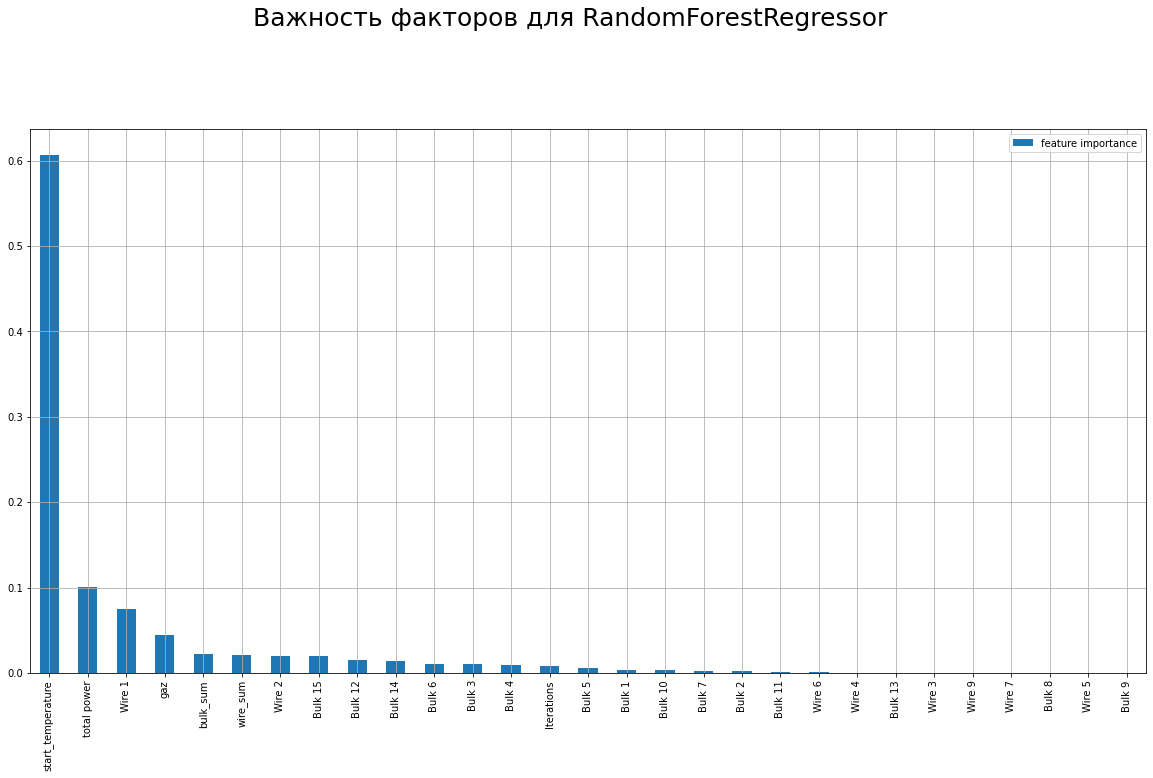

In [76]:
df_feature_importance = pd.DataFrame(regr_model.feature_importances_, index=features.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance.plot(kind='bar', grid = True, figsize=(20, 10))
plt.suptitle('Важность факторов для RandomForestRegressor', x=0.5, y=1.05, ha='center', fontsize=25)
plt.show()

In [77]:
finalle = {'RandomForestRegressor':np.array([reg_mae]),
           'LGBM':np.array([light_mae]),
           'Catboost':np.array([cat_mae])}
finalle = pd.DataFrame(finalle, index = ['Значения MAE'])
finalle

,RandomForestRegressor,LGBM,Catboost
Значения MAE,6.849,6.686,6.047


# Вывод по третьей части

В данной части мы выполнили следующие шаги: 
*   Определили наши фичи и таргет. В признаках удалили также столбец, у которого была высокая корреляция с другим столбцом из датасета(конец 2 части исследования)
*   Масштабировали признаки
*   Провели исследования на трех моделях: 
**LGBM**, **Catboost**, **RandomForestRegressor**. Для каждой сначала провели Grid search для оптимизации и поиска оптимальных параметров для лучшего результата на тестовой выборке. Определили **MAE** через  функцию **make_scorer()**, правда по ее использованию остались вопросы.
*  для каждой модели мы провели визуализацию важности признаков. Именно это помогло в обработке данных во второй части.
По итогу Catboost и LGBM справились с задачей. Однако время для нахождения параметров для Catboost тратится значительно меньше чем для LGBM, да и показатели значительно лучше. Наши рекомендации - использовать Catboost. Однако не все так однозначно: согласно комментариям выше от Николая, думаю можно было бы добиться лучшего результата. Например как вариант использовать время в нашем исследовании: косинус и синус (насколько помню, уже один раз использовали в одном из проектов). 



"В отчёте ответьте на вопросы:
- Какие пункты плана были выполнены, а какие — нет (поясните почему)?
- Какие трудности возникли и как вы их преодолели?
- Какие ключевые шаги в решении задачи выделили?
- Какая ваша итоговая модель и какое у неё качество?

Ответы на вопросы:

1) В целом все пункты плана были выполнены. Обработали все данные, создали модели, проверили их, нашли лучшую модель

2) Было несколько трудностей при выполнения проекта: 

1.   Постановка задачи. С самого начала совершенно не понимал, что необходимо сделать в проекте. Очеень сильно помогли семинары с руководителем, а также дополнительная литература по данному технологическогому процессу для общего понимания.
2.   Как вообще обрабатывать данные? В **исследовательской части** в первую очередь ставил задачу почистить пропуски, проверить возможно корреляцию и соединить все таблицы. После неуспешных попыток построить модели которые бы дали **MAE** меньше 8, решил начать разбираться с выбросами в каждой исходной таблице. Прочитал информацию про температуру плавления. После того как построил модели и нашел важность факторов еще раз пересмотрел "борьбу" с выбросами. Поссле этого также и ввел новый параметр с суммами добавок проволочных и сыпучих материалов. Можно было бы еще поисследовать, и, например, рассмотреть вариант с добавлением количества времени между первым и последнем этапом.
3. Построение модели, поиск гиперпараметров. Очень большое время потратил на LGBM, фактически уперся только в эту модель. очень долго настраивал различные гиперпараметры, довел до того, что модель искала лучшие около 20 минут. После этого обучил **Catboost**, который сразу показал **MAE 7**, что было лучше, чем у **LGBM**. Решил поменять тактику, проверил важность признаков, вернулся на второй этап с обработкой данных. Очень сильно повлияла и описанная выше функция **make_scorer()**. Насколько я помню, она используется в **Grid Search**, если такая метрика отсутствует по умолчанию. Постоянно на трейне выдавало отрицательные числа. Сразу подумл, что считается **neg_mae**, но адекватного объяснения так и не нашел.
4. Построение графиков с важностью признаков. Именно то, что не построил сразу их у** LGBM** повлияло на количество потраченного времени.


3)Ключевые шаги: использование важности признаков в моделях, подбор гиперпараметров, удаление выбросов.

4) Итоговая модель: **Catboost, качество MAE 6.047**

В целом могу сказать, что проект был очень интресным, огромное благодарность Николаю за комментарии, и будущему ревьюеру, надеюсь удалось успешно завершить данный проект.


